In [1]:
import ruamel.yaml as yaml
import os
import sys
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

NO_CONFIG_ERR_MSG = """No config file found. Root directory is determined by presence of "config.yaml" file."""

original_wd = os.getcwd()

# Number of times to move back in directory
num_retries = 10
for x in range(0, num_retries):
    # try to load config file
    try:
        with open("config.yaml", 'r') as stream:
            cfg = yaml.safe_load(stream)
    # If not found move back one directory level
    except FileNotFoundError:
        os.chdir('../')
        # If reached the max number of directory levels change to original wd and print error msg
        if x+1 == num_retries:
            os.chdir(original_wd)
            print(NO_CONFIG_ERR_MSG)

# Add directory to PATH
path = os.getcwd()

if path not in sys.path:
    sys.path.append(path)


## Load and Process Data

In [2]:
df = pd.read_csv('data/processed/model_data.csv')

One Hot Encode the season

In [3]:
features= [
 'WINS_score',
 'market_size',
 'superteam_flg']
target = [
    'team_value'
]

season_on_hot = pd.get_dummies(df['Season']).add_prefix('Season_')

X = pd.merge(season_on_hot, df[features], left_index=True, right_index=True)
Y = df['team_value']

X_train, X_test, y_train, y_test = train_test_split(X, Y)

# Best parameters found from grid search
best_params ={'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 11,
 'missing': -999,
 'n_estimators': 500,
 'nthread': 4,
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

## Fit Model

In [4]:
%%time
xgb_model = xgb.XGBRegressor(**best_params)

xgb_model.fit(X, Y)

Wall time: 73 ms


## XGB modelled feature importance

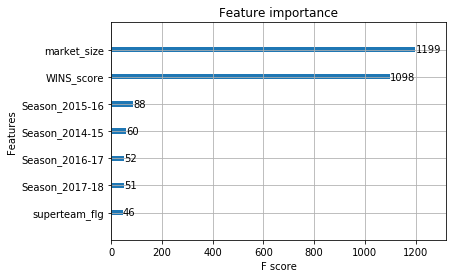

In [5]:
xgb.plot_importance(xgb_model)

## Shapley Values

In [18]:
%%time
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

Wall time: 28 ms


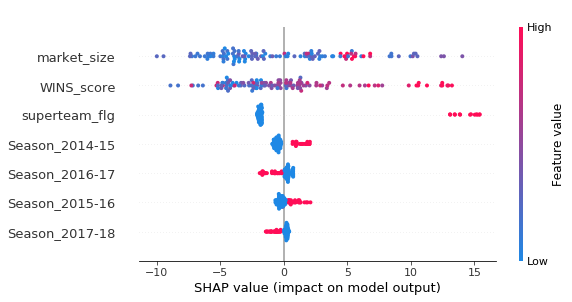

Wall time: 220 ms


In [11]:
%%time
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

#### X axis is index (instance of team and season)

#### y is the team value

#### Red/Blue are the direction the value is 'pushed' by its feature value

In [12]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

## Single Effect

#### X axis is feature value

#### y is the associated shapley value (ouput impact)

#### Red/Blue is a value of potential interaction effect

WINS_score


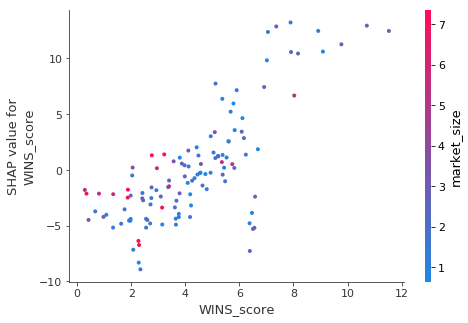

market_size


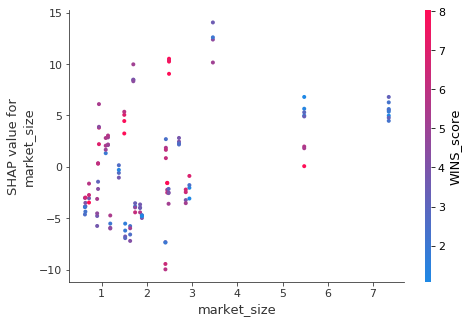

superteam_flg


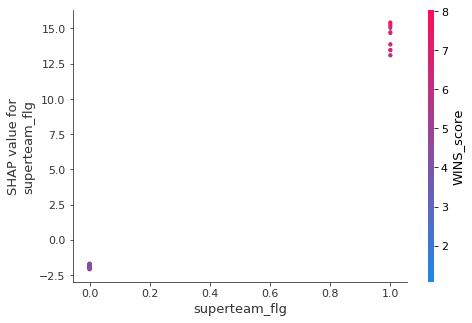

In [19]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
for feature in df[features].columns.values.tolist():
    print(feature)
    shap.dependence_plot(feature, shap_values, X)

## Which features are cumulatively most important?

Avg(Abs Value of Features Shapley Values)

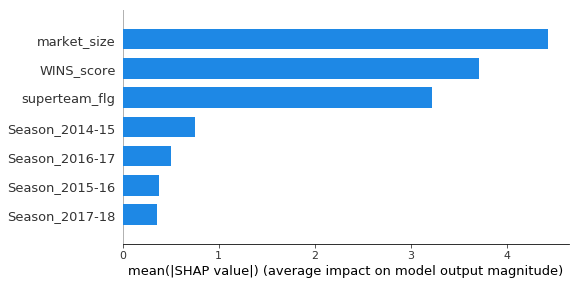

In [14]:
shap.summary_plot(shap_values, X, plot_type="bar")